<a href="https://colab.research.google.com/github/ryamaguchi0111/Advanced-Deep-Learning-with-Pytorch/blob/master/3_semantic_segmentation/3_8_PSPNet_inference_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.8 推論の実施

- 本ファイルでは、学習させたPSPNetでセマンティックセグメンテーションを行います。


# 学習目標


1.	セマンティックセグメンテーションの推論を実装できるようになる


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
ROOT_PATH = '/content/drive/My Drive/semantic_segmentation/'

# 事前準備

- 学習させた重みパラメータ「pspnet50_30.pth」をフォルダ「weights」に用意する。

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [4]:
import sys
sys.path.append(ROOT_PATH)

# ファイルパスリストを用意

In [5]:
from utils.dataloader import make_datapath_list, DataTransform


# ファイルパスリスト作成
rootpath = ROOT_PATH + "data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 後ほどアノテーション画像のみを使用する


# ネットワークを用意

In [7]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 学習済みパラメータをロード
state_dict = torch.load(ROOT_PATH + "weights/pspnet50_29.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('ネットワーク設定完了：学習済みの重みをロードしました')


ネットワーク設定完了：学習済みの重みをロードしました


# 推論実行

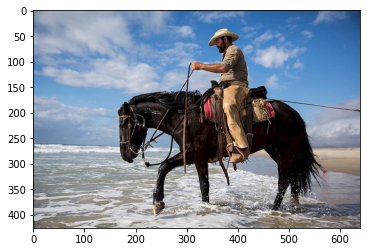

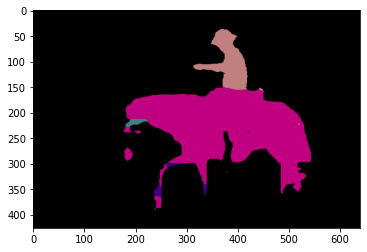

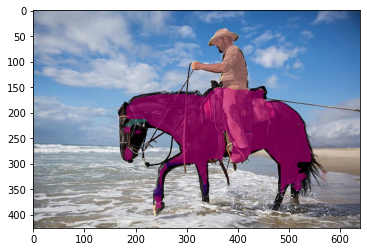

In [8]:
# 1. 元画像の表示
image_file_path = ROOT_PATH + "data/cowboy-757575_640.jpg"
img = Image.open(image_file_path)   # [高さ][幅][色RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 前処理クラスの作成
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 前処理
# 適当なアノテーション画像を用意し、さらにカラーパレットの情報を抜き出す
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [高さ][幅]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)


# 4. PSPNetで推論する
net.eval()
x = img.unsqueeze(0)  # ミニバッチ化：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss側は無視 yのサイズはtorch.Size([1, 21, 475, 475])


# 5. PSPNetの出力から最大クラスを求め、カラーパレット形式にし、画像サイズを元に戻す
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()


# 6. 画像を透過させて重ねる
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # カラーパレット形式をRGBAに変換

for x in range(img_width):
    for y in range(img_height):
        # 推論結果画像のピクセルデータを取得
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)の背景ならそのままにして透過させる
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # それ以外の色は用意した画像にピクセルを書き込む
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 150は透過度の大きさを指定している

img = Image.open(image_file_path)   # [高さ][幅][色RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()


以上